Questions

- Can I get transfer-learning accuracy using just the previous steps
    - If yes, can we try visualizing the other vs transfer-learning and understand the differences?
- What are the improvements in each steps?
- Can we try the same for breeds? What is accuracy in that case?

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import os
import PIL
import PIL.Image

from collections import Counter
import pathlib

print("TensorFlow Versions: ", tf.__version__)
if tf.config.list_physical_devices('GPU'):
  print("TensorFlow **IS** using the GPU")
else:
  print("TensorFlow **IS NOT** using the GPU")

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)


TensorFlow Versions:  2.7.0
TensorFlow **IS** using the GPU


In [2]:
batch_size = 32
img_size = (160, 160)
seed = 120

epochs = 10

data_dir = pathlib.Path('/home/addy/.keras/datasets/pets_photos')

In [3]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=seed,
  image_size=img_size,
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=seed,
  image_size=img_size,
  batch_size=batch_size)

val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)


Found 7390 files belonging to 2 classes.
Using 5912 files for training.
Found 7390 files belonging to 2 classes.
Using 1478 files for validation.


2021-12-30 23:22:07.175305: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-30 23:22:07.580829: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4234 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1660 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5


In [4]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_ds.prefetch(buffer_size=AUTOTUNE)
validation_dataset = val_ds.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_ds.prefetch(buffer_size=AUTOTUNE)


In [5]:
resize_and_augment = tf.keras.Sequential(
  [
    tf.keras.layers.RandomCrop(img_size[0], img_size[1]),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
  ]
)


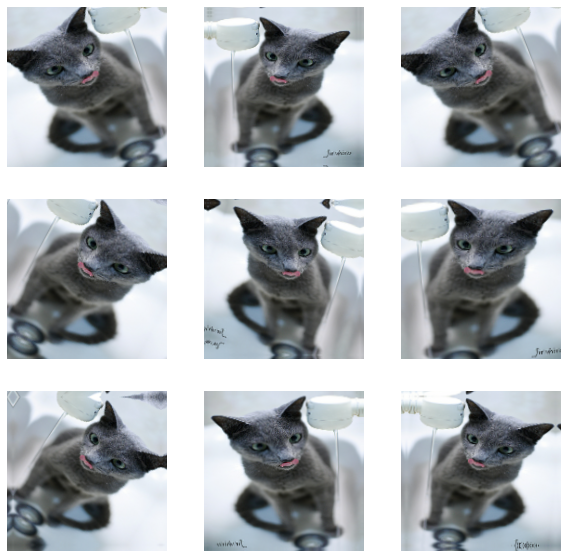

In [6]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = resize_and_augment(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')


In [7]:
IMG_SHAPE = img_size + (3,)
IMG_SHAPE


(160, 160, 3)

In [8]:
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')


In [9]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(resize_and_augment(image_batch))
print(feature_batch.shape)


2021-12-30 23:22:29.868438: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8301


(32, 5, 5, 1280)


2021-12-30 23:22:30.330805: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [10]:
base_model.trainable = False
base_model.summary()


Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [11]:
# Create new model on top
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = resize_and_augment(inputs)  # Apply random data augmentation

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = tf.keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 160, 160, 3)       0         
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0     

In [12]:
loss0, accuracy0 = model.evaluate(validation_dataset)


38/38 [==============================] - 3s 31ms/step - loss: 0.8584 - accuracy: 0.3521


In [13]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))


initial loss: 0.86
initial accuracy: 0.35


In [14]:
history = model.fit(train_dataset,
                    epochs=epochs,
                    validation_data=validation_dataset)


Epoch 1/10
 16/185 [=>............................] - ETA: 4s - loss: 0.7693 - accuracy: 0.4375

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


143/185 [======================>.......] - ETA: 1s - loss: 0.5488 - accuracy: 0.6764

Corrupt JPEG data: premature end of data segment


185/185 [==============================] - 8s 32ms/step - loss: 0.5104 - accuracy: 0.7099 - val_loss: 0.3169 - val_accuracy: 0.8563
Epoch 2/10
 15/185 [=>............................] - ETA: 4s - loss: 0.3187 - accuracy: 0.8750

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


141/185 [=====================>........] - ETA: 1s - loss: 0.2999 - accuracy: 0.8854

Corrupt JPEG data: premature end of data segment


185/185 [==============================] - 6s 34ms/step - loss: 0.2877 - accuracy: 0.8924 - val_loss: 0.2090 - val_accuracy: 0.9176
Epoch 3/10
 15/185 [=>............................] - ETA: 4s - loss: 0.2264 - accuracy: 0.9167

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


141/185 [=====================>........] - ETA: 1s - loss: 0.2148 - accuracy: 0.9304

Corrupt JPEG data: premature end of data segment


185/185 [==============================] - 6s 34ms/step - loss: 0.2089 - accuracy: 0.9325 - val_loss: 0.1554 - val_accuracy: 0.9513
Epoch 4/10
 15/185 [=>............................] - ETA: 4s - loss: 0.1903 - accuracy: 0.9375

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


141/185 [=====================>........] - ETA: 1s - loss: 0.1722 - accuracy: 0.9464

Corrupt JPEG data: premature end of data segment


185/185 [==============================] - 6s 33ms/step - loss: 0.1686 - accuracy: 0.9479 - val_loss: 0.1285 - val_accuracy: 0.9630
Epoch 5/10
 16/185 [=>............................] - ETA: 4s - loss: 0.1570 - accuracy: 0.9453

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


142/185 [======================>.......] - ETA: 1s - loss: 0.1486 - accuracy: 0.9564

Corrupt JPEG data: premature end of data segment


185/185 [==============================] - 6s 33ms/step - loss: 0.1482 - accuracy: 0.9562 - val_loss: 0.1090 - val_accuracy: 0.9697
Epoch 6/10
 17/185 [=>............................] - ETA: 4s - loss: 0.1520 - accuracy: 0.9559

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


141/185 [=====================>........] - ETA: 1s - loss: 0.1310 - accuracy: 0.9619

Corrupt JPEG data: premature end of data segment


185/185 [==============================] - 6s 33ms/step - loss: 0.1306 - accuracy: 0.9623 - val_loss: 0.0960 - val_accuracy: 0.9756
Epoch 7/10
 16/185 [=>............................] - ETA: 4s - loss: 0.1289 - accuracy: 0.9473

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


142/185 [======================>.......] - ETA: 1s - loss: 0.1182 - accuracy: 0.9661

Corrupt JPEG data: premature end of data segment


185/185 [==============================] - 6s 33ms/step - loss: 0.1187 - accuracy: 0.9645 - val_loss: 0.0806 - val_accuracy: 0.9790
Epoch 8/10
 15/185 [=>............................] - ETA: 4s - loss: 0.1064 - accuracy: 0.9625

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


142/185 [======================>.......] - ETA: 1s - loss: 0.1052 - accuracy: 0.9670

Corrupt JPEG data: premature end of data segment


185/185 [==============================] - 6s 33ms/step - loss: 0.1068 - accuracy: 0.9667 - val_loss: 0.0818 - val_accuracy: 0.9798
Epoch 9/10
 15/185 [=>............................] - ETA: 4s - loss: 0.1117 - accuracy: 0.9542

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


141/185 [=====================>........] - ETA: 1s - loss: 0.1040 - accuracy: 0.9674

Corrupt JPEG data: premature end of data segment


185/185 [==============================] - 6s 33ms/step - loss: 0.1040 - accuracy: 0.9682 - val_loss: 0.0696 - val_accuracy: 0.9857
Epoch 10/10
 17/185 [=>............................] - ETA: 4s - loss: 0.1066 - accuracy: 0.9540

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


141/185 [=====================>........] - ETA: 1s - loss: 0.0958 - accuracy: 0.9685

Corrupt JPEG data: premature end of data segment


185/185 [==============================] - 6s 33ms/step - loss: 0.0989 - accuracy: 0.9675 - val_loss: 0.0669 - val_accuracy: 0.9849


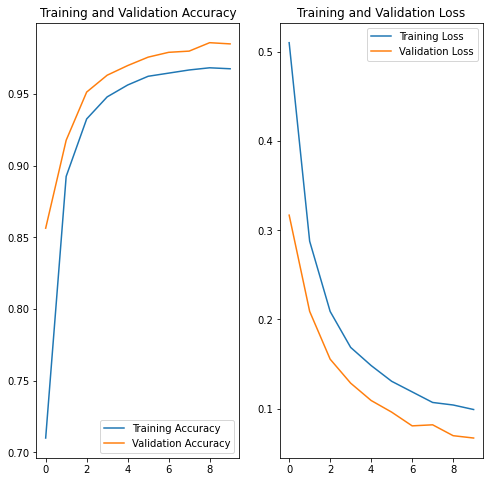

In [15]:
def plotTrainingGraphs(history, epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

plotTrainingGraphs(history, epochs)



In [16]:
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False


Number of layers in the base model:  154


In [17]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])


In [18]:
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 160, 160, 3)       0         
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0     

In [19]:
fine_tune_epochs = 10
total_epochs =  epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)


Epoch 10/20
 13/185 [=>............................] - ETA: 6s - loss: 0.0717 - accuracy: 0.9784

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


141/185 [=====================>........] - ETA: 1s - loss: 0.0711 - accuracy: 0.9721

Corrupt JPEG data: premature end of data segment


185/185 [==============================] - 12s 47ms/step - loss: 0.0717 - accuracy: 0.9724 - val_loss: 0.0358 - val_accuracy: 0.9908
Epoch 11/20
 13/185 [=>............................] - ETA: 6s - loss: 0.0817 - accuracy: 0.9639

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


141/185 [=====================>........] - ETA: 1s - loss: 0.0555 - accuracy: 0.9798

Corrupt JPEG data: premature end of data segment


185/185 [==============================] - 8s 42ms/step - loss: 0.0546 - accuracy: 0.9802 - val_loss: 0.0322 - val_accuracy: 0.9891
Epoch 12/20
 13/185 [=>............................] - ETA: 6s - loss: 0.0299 - accuracy: 0.9880

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


141/185 [=====================>........] - ETA: 1s - loss: 0.0523 - accuracy: 0.9781

Corrupt JPEG data: premature end of data segment


185/185 [==============================] - 8s 43ms/step - loss: 0.0517 - accuracy: 0.9787 - val_loss: 0.0369 - val_accuracy: 0.9882
Epoch 13/20
 13/185 [=>............................] - ETA: 6s - loss: 0.0302 - accuracy: 0.9904

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


141/185 [=====================>........] - ETA: 1s - loss: 0.0405 - accuracy: 0.9847

Corrupt JPEG data: premature end of data segment


185/185 [==============================] - 8s 42ms/step - loss: 0.0413 - accuracy: 0.9849 - val_loss: 0.0390 - val_accuracy: 0.9874
Epoch 14/20
 13/185 [=>............................] - ETA: 6s - loss: 0.0340 - accuracy: 0.9856

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


141/185 [=====================>........] - ETA: 1s - loss: 0.0375 - accuracy: 0.9829

Corrupt JPEG data: premature end of data segment


185/185 [==============================] - 8s 42ms/step - loss: 0.0358 - accuracy: 0.9839 - val_loss: 0.0286 - val_accuracy: 0.9916
Epoch 15/20
 13/185 [=>............................] - ETA: 6s - loss: 0.0260 - accuracy: 0.9904

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


141/185 [=====================>........] - ETA: 1s - loss: 0.0289 - accuracy: 0.9894

Corrupt JPEG data: premature end of data segment


185/185 [==============================] - 8s 42ms/step - loss: 0.0297 - accuracy: 0.9890 - val_loss: 0.0332 - val_accuracy: 0.9899
Epoch 16/20
 13/185 [=>............................] - ETA: 6s - loss: 0.0232 - accuracy: 0.9904

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


141/185 [=====================>........] - ETA: 1s - loss: 0.0232 - accuracy: 0.9911

Corrupt JPEG data: premature end of data segment


185/185 [==============================] - 8s 42ms/step - loss: 0.0240 - accuracy: 0.9909 - val_loss: 0.0296 - val_accuracy: 0.9899
Epoch 17/20
 13/185 [=>............................] - ETA: 6s - loss: 0.0140 - accuracy: 0.9952

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


141/185 [=====================>........] - ETA: 1s - loss: 0.0248 - accuracy: 0.9907

Corrupt JPEG data: premature end of data segment


185/185 [==============================] - 8s 42ms/step - loss: 0.0227 - accuracy: 0.9914 - val_loss: 0.0322 - val_accuracy: 0.9899
Epoch 18/20
 13/185 [=>............................] - ETA: 6s - loss: 0.0412 - accuracy: 0.9832

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


141/185 [=====================>........] - ETA: 1s - loss: 0.0294 - accuracy: 0.9891

Corrupt JPEG data: premature end of data segment


185/185 [==============================] - 8s 42ms/step - loss: 0.0295 - accuracy: 0.9897 - val_loss: 0.0295 - val_accuracy: 0.9899
Epoch 19/20
 13/185 [=>............................] - ETA: 6s - loss: 0.0333 - accuracy: 0.9880

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


141/185 [=====================>........] - ETA: 1s - loss: 0.0249 - accuracy: 0.9905

Corrupt JPEG data: premature end of data segment


185/185 [==============================] - 8s 43ms/step - loss: 0.0239 - accuracy: 0.9914 - val_loss: 0.0427 - val_accuracy: 0.9866
Epoch 20/20
 13/185 [=>............................] - ETA: 6s - loss: 0.0116 - accuracy: 0.9976

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


141/185 [=====================>........] - ETA: 1s - loss: 0.0190 - accuracy: 0.9929

Corrupt JPEG data: premature end of data segment


185/185 [==============================] - 8s 42ms/step - loss: 0.0176 - accuracy: 0.9934 - val_loss: 0.0287 - val_accuracy: 0.9908


In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']


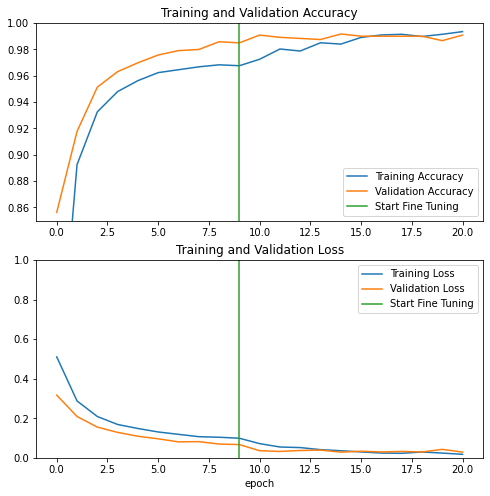

In [24]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.85, 1])
plt.plot([epochs-1,epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([epochs-1,epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()
